In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
from pycaret.regression import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error as RMSE

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# def make_lag_feats(df, tar, lags):
#     for i in lags:
#         df[f'{tar}_lag{i}'] = df[tar].shift(i)
#     return df

def make_lag_feats(df, tars, lags):
    for i in lags:
        for t in tars:
            df[f'{t}_lag{i}'] = df[t].shift(i)
#             if i in [24, 168, 336]:
                df[f'{t}_cng{i}'] = df[f'{t}_lag{i}'].pct_change(24)
#             if i in [120, 144]:
            df[f'{t}_diff{i}'] = df[f'{t}_lag{i}'].diff(24)
    return df

def agg_feats(data, y):
    data['date'] = data.index.map(lambda x: pd.to_datetime(x.date())).values
    df = data.groupby('date', as_index=False).agg({y + '_lag24' : ['sum', 'mean', 'median', 'var', 'max', 'min']})
    df.columns = df.columns.map('_'.join)
    df.columns = ['date', 'last_day_sum', 'last_day_mean', 'last_day_median', 'last_day_var', 'last_day_max', 'last_day_min']
    data = data.reset_index()
    data = data.merge(df, how='left').drop('date', axis=1)
    data = data.set_index('Datetime')
    return data


In [19]:
df = pd.read_csv('ready_for_eat.csv', index_col=0)
df.Datetime = df.Datetime.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')).values

data = pd.read_csv('data_UTC.csv')
data.Datetime = data.Datetime.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')).values
data.Datetime = (data.Datetime + timedelta(hours=3)).values

df = df[['Datetime', 'y1', 'y2', 'y3', 'y4']].merge(data, how='left')

### human-factor

df['date'] = df.Datetime.map(lambda x: pd.to_datetime(x.date())).values

human = pd.read_csv('human_factor.csv', index_col=0)
human.date = human.date.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d')).values

df = df.merge(human, how='left')
df = df.drop('date', axis=1)
df.human_factor = df.human_factor.fillna(0).values

# очистка лагов от выходных дней

df = df.set_index('Datetime')

df.loc[(df["All_weekends"] == 1), ["y1", "y2", "y3", "y4"]] = None
df.loc[:, ["y1", "y2", "y3", "y4"]] = df.groupby('hour')["y1", "y2", "y3", "y4"].fillna(method='ffill').sort_index()

In [20]:
# прогнозирование нагрузки по входу


# выбор входа

y = set(['y1'])

# отсеивание остальных входов

lst_y = set(['y1', 'y2', 'y3', 'y4'])
df = df.drop(list(lst_y - y), axis=1)
y = list(y)[0]

# правильные лаги

df = make_lag_feats(df, [y], [24, 48, 72, 96, 120, 144, 168, 192, 336])
df = df[(df.All_weekends == 0)]
df = df.dropna()

# нужные часы

df = df[(df.hour >= 7) & (df.hour <= 22)]

# агрегаты за прошлый рабочий день

df = agg_feats(df, y)

# убираем неинформативное

num_rows = len(df.index)
low_information_cols = []
for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    if top_pct > 0.95:
        low_information_cols.append(col)
        
df = df.drop(low_information_cols, axis=1)


# train-test split

split = '2020-10-01'
test = df[(df.index>=split)  & (df.index<'2020-12-31')]
train = df[(df.index<split)]

# modeling

reg = setup(data = train,
            data_split_shuffle = False,
            feature_selection = True,
            feature_selection_method = 'boruta',
            fold_strategy = 'timeseries',
            train_size = 0.8,
            target = y,
            categorical_features = ['hour', 'month', 'cloudy', 'weekday'])

compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.2491,13.8075,3.2117,0.7743,0.1275,0.0957,0.1010
et,Extra Trees Regressor,2.2374,13.8326,3.2258,0.7722,0.1248,0.0939,0.4430
gbr,Gradient Boosting Regressor,2.3771,15.8460,3.4036,0.7360,0.1330,0.1006,0.3810
catboost,CatBoost Regressor,2.1803,13.1339,3.1824,0.7330,0.1251,0.0940,5.3480
ada,AdaBoost Regressor,2.3386,14.7031,3.3924,0.7110,0.1389,0.1075,0.1550
xgboost,Extreme Gradient Boosting,2.5219,17.2173,3.6022,0.6642,0.1438,0.1065,0.5420
rf,Random Forest Regressor,2.3420,15.8133,3.4255,0.6454,0.1374,0.1015,0.9000
dt,Decision Tree Regressor,2.9153,21.9000,4.3173,0.3216,0.1689,0.1249,0.0220
knn,K Neighbors Regressor,3.1952,25.4338,4.4487,0.3147,0.1789,0.1379,0.0140
huber,Huber Regressor,2.2972,13.4235,3.1868,0.2904,0.1375,0.1051,0.0450


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=3598, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
# финализация модели

model = finalize_model('catboost')
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

5.186812211583709
1.8202171462086547


<AxesSubplot:xlabel='Datetime'>

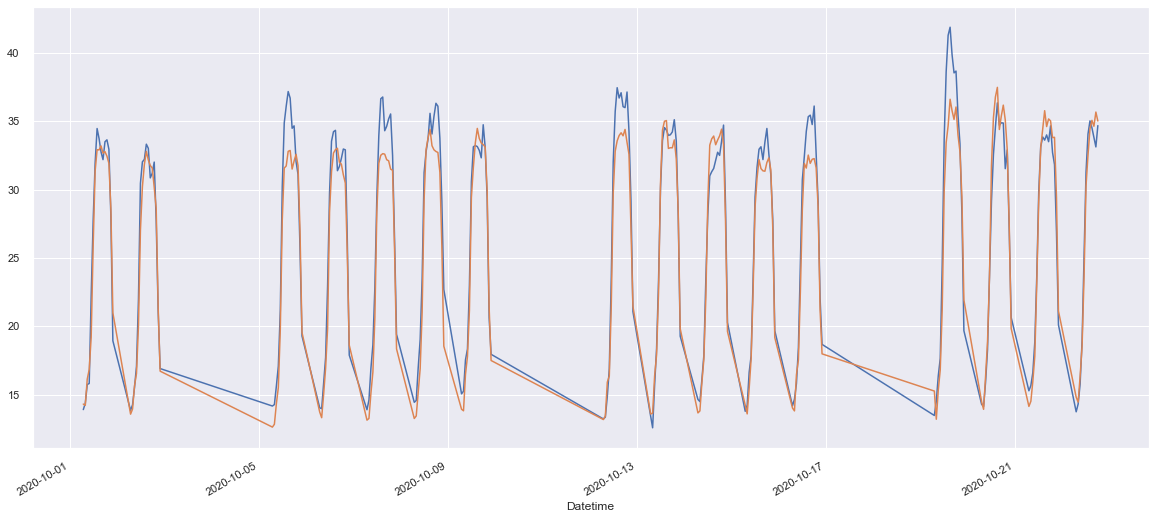

In [22]:
# точность на тесте

pred = predict_model(model, data = test).Label
test_y = test[y]

sns.set(rc={'figure.figsize' : (20, 9)})

print(MAPE(test_y, pred))
print(RMSE(test_y, pred, squared=False))

test_y.plot()
pred.plot()